In [2]:
%matplotlib inline
import sys
import os
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid

In [4]:
# Import the latitudes and longitudes

# Note: We couldn't upload the data COBEv2_ssta.nc in Github.

import netCDF4
from netCDF4 import Dataset
def importNetcdf(path,variable_name):
    nc_fid = Dataset(path, 'r')
    field = nc_fid.variables[variable_name][:]     
    return field 

path = '../Data/IO_detrended_anomalies.nc'

lon = importNetcdf(path,'longitude')
lat = importNetcdf(path,'latitude')

## A look at the local homogeneity field and seeds

In [12]:
# Function to plot based on Basemap
def plot(field,vmax,vmin,title):

    fig = plt.figure()
    ax = fig.add_axes([0,0,2,2])
    
    map = Basemap(projection='cyl',
              llcrnrlat=-20,urcrnrlat=30,\
            llcrnrlon=40,urcrnrlon=115)
    map.drawcoastlines()
    #map.drawparallels(np.arange(-90.,100.,30.), \
    #  labels=[1,0,0,0],fontsize = 20,linewidth = 0)
    #map.drawmeridians(np.arange(0.,360.,60.), \
    #  labels=[0,0,0,1],fontsize = 20,linewidth = 0)
    #map.fillcontinents(color = 'black')
    
    map.pcolor(lon,lat,field,cmap=plt.cm.viridis,vmax = vmax, vmin=vmin)
    cb=plt.colorbar(location='bottom',aspect=20,pad=0.08)
    cb.ax.tick_params(labelsize=37)
    
    plt.title(title, fontsize = 33)

In [6]:
# Path to the homogeneity field
path_homogeneity = './outputs_test_2/seed_identification/local_homogeneity_field.npy'
# Path to the seed positions
path_seeds = './outputs_test_2/seed_identification/seed_positions.npy'
# Import the homogeneity field
homogeneity_field = np.load(path_homogeneity)
# Import the seeds location
seeds = np.load(path_seeds)

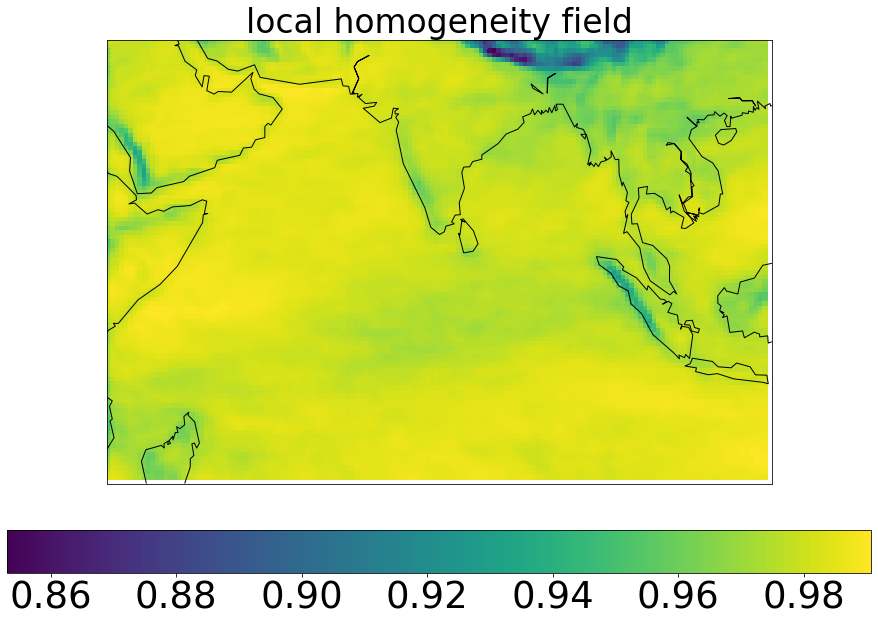

In [13]:
plot(homogeneity_field,np.nanmax(homogeneity_field),np.nanmin(homogeneity_field),"local homogeneity field")

In [41]:
np.shape(seeds)

(100, 150)

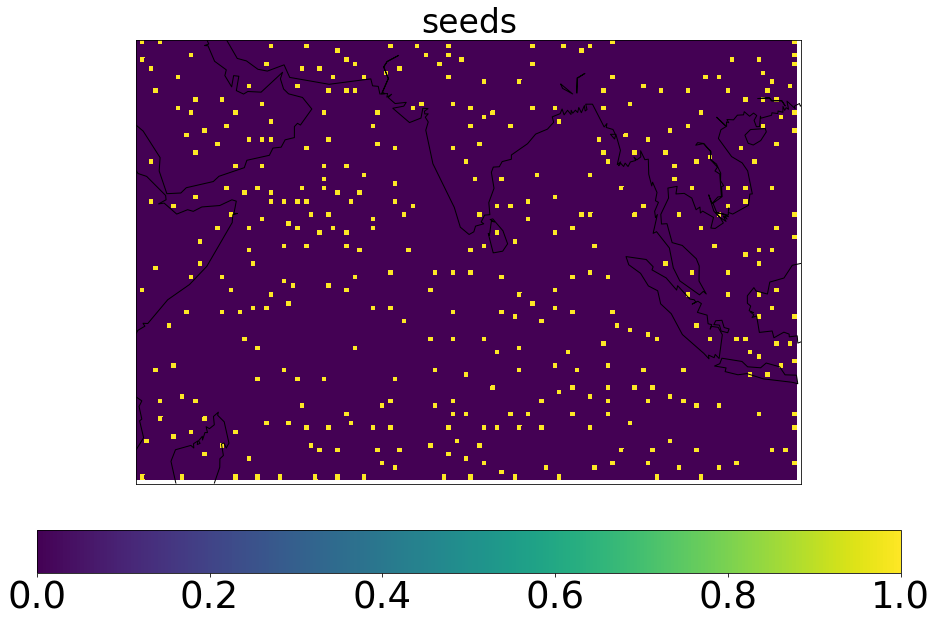

In [14]:
plot(seeds,1,0,"seeds")

## A look at the domains identified

Results of the domain identification are in "./outputs_COBEv2/domain_identification"

Here you will find 2 arrays:

(a) domain_maps.npy
(b) domain_ids.npy

The domain_maps array contains the N domains identified. Grid cells in a domain are equal to 1, if outside they are equal to 0.
The domain_ids array contains the ids of the N domains.

(i.e., domain_ids[0] will be the id of domain_maps[0] etc.)

In [15]:
# Path to the domain maps
path_domain_maps = './outputs_test_2/domain_identification/domain_maps.npy'
# Path to the domain ids
path_domain_ids = './outputs_test_2/domain_identification/domain_ids.npy'
# Import domain maps
d_maps = np.load(path_domain_maps)
# Import domain ids
d_ids = np.load(path_domain_ids)

In [43]:
d_maps_to_plot = d_maps.copy()

In [44]:
d_maps_to_plot[d_maps_to_plot==0] = np.nan

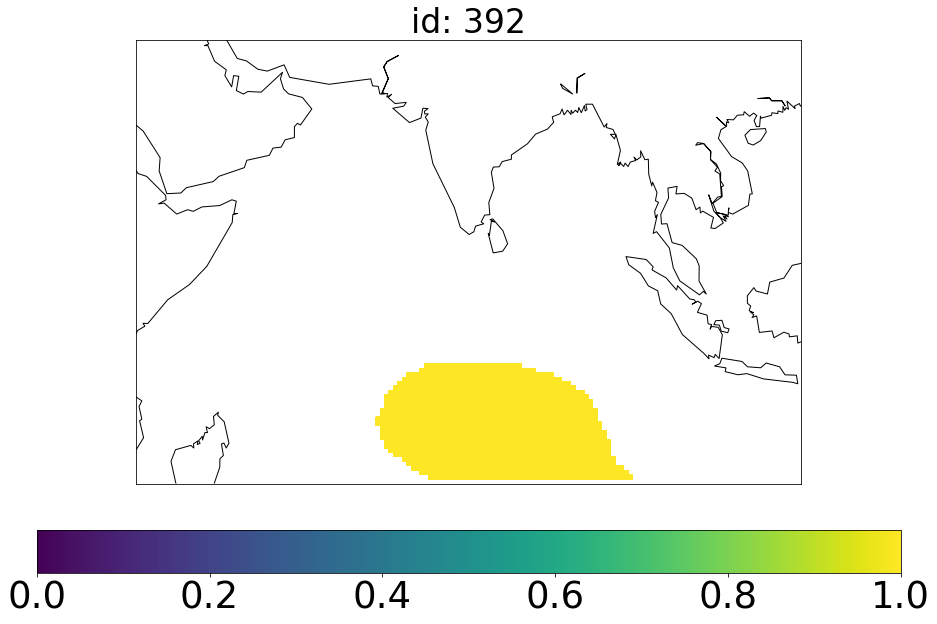

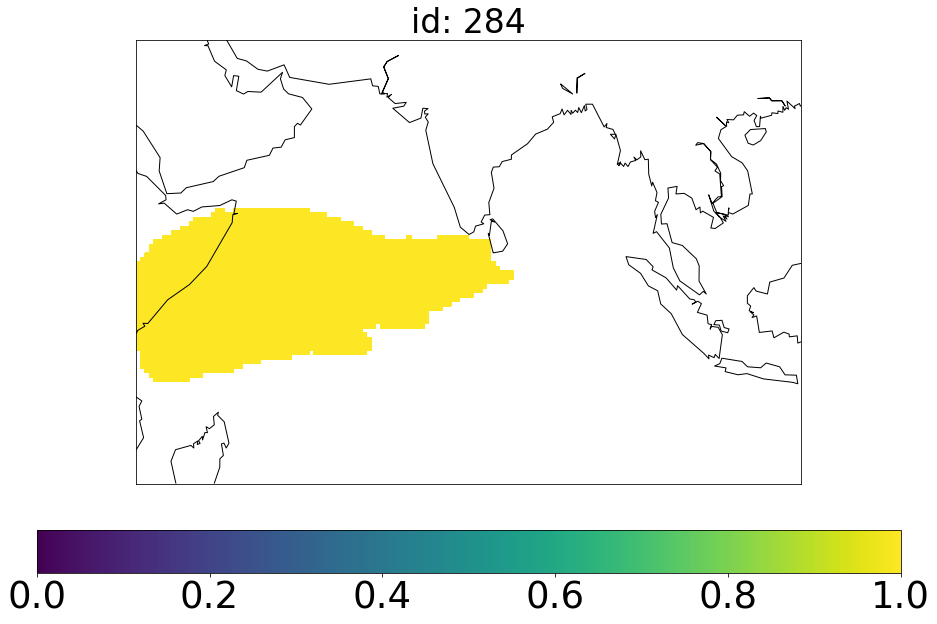

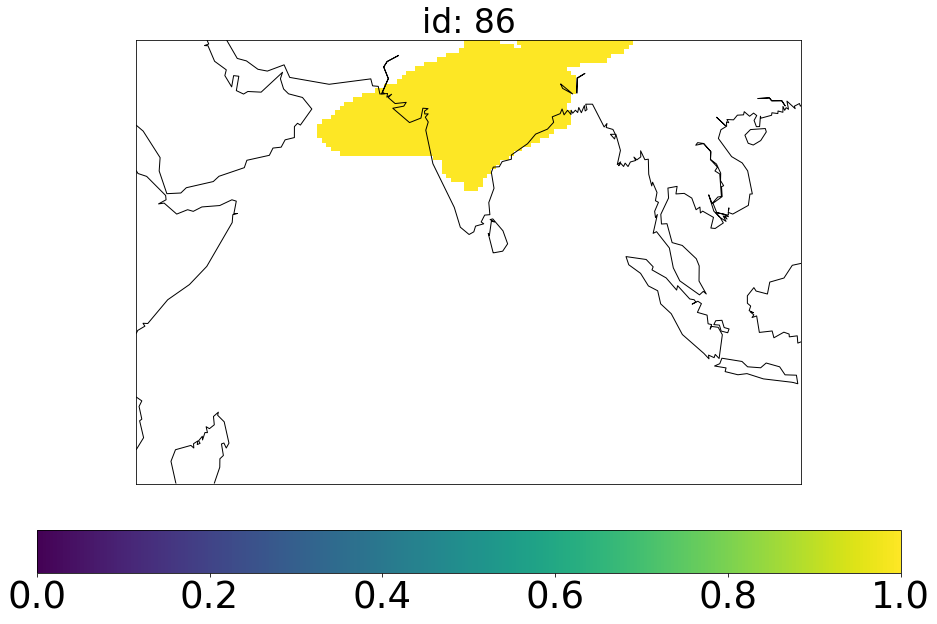

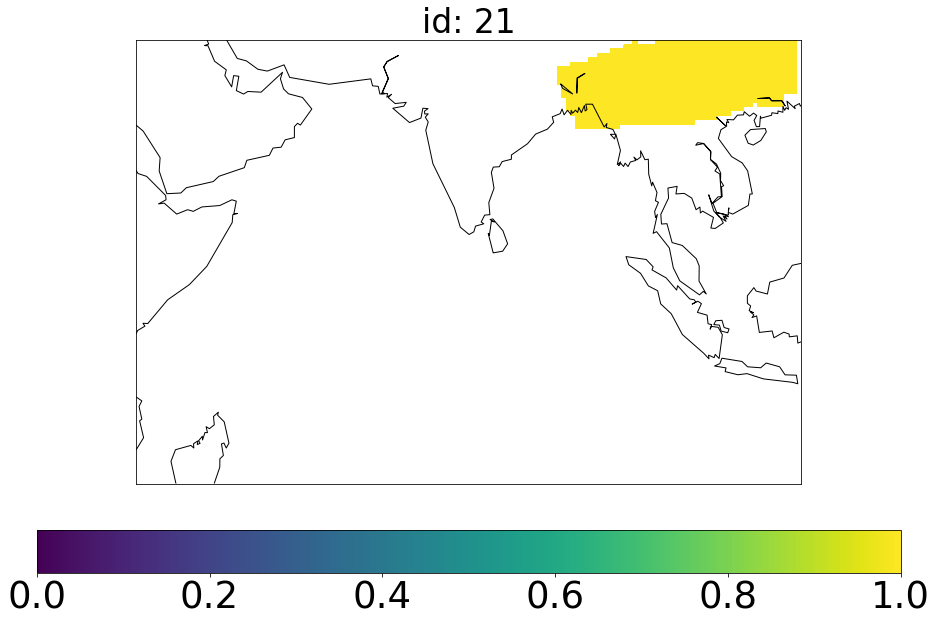

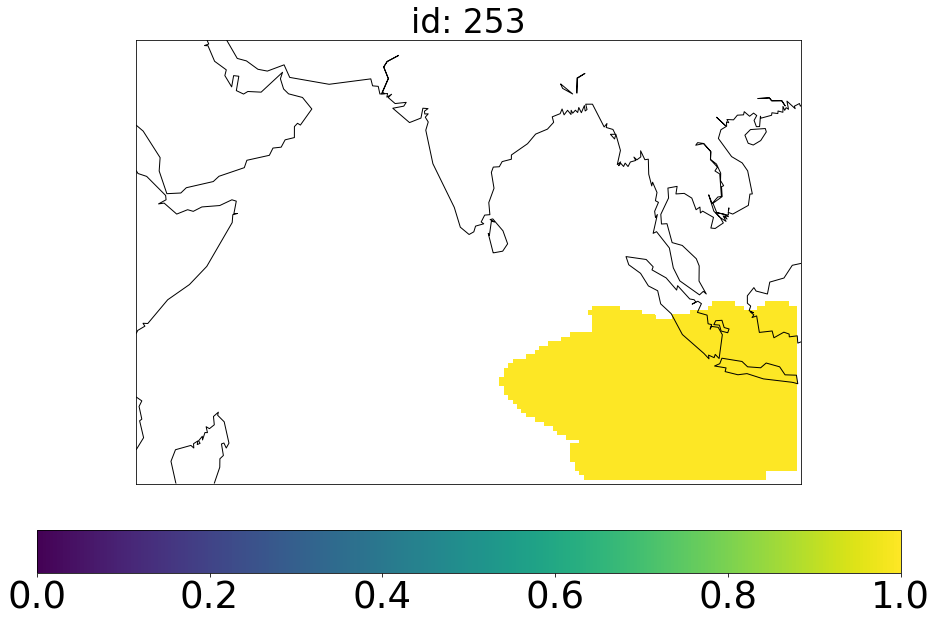

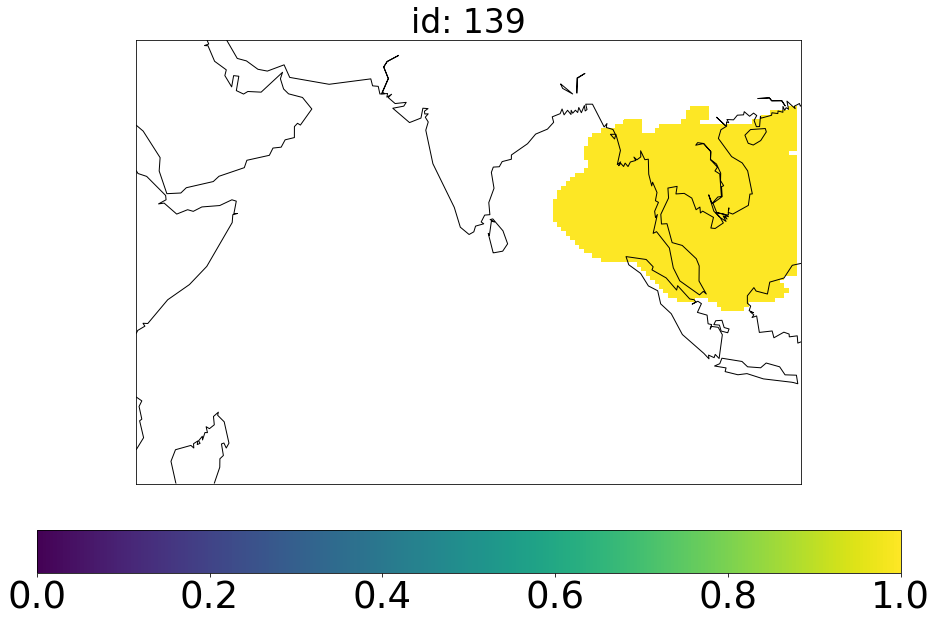

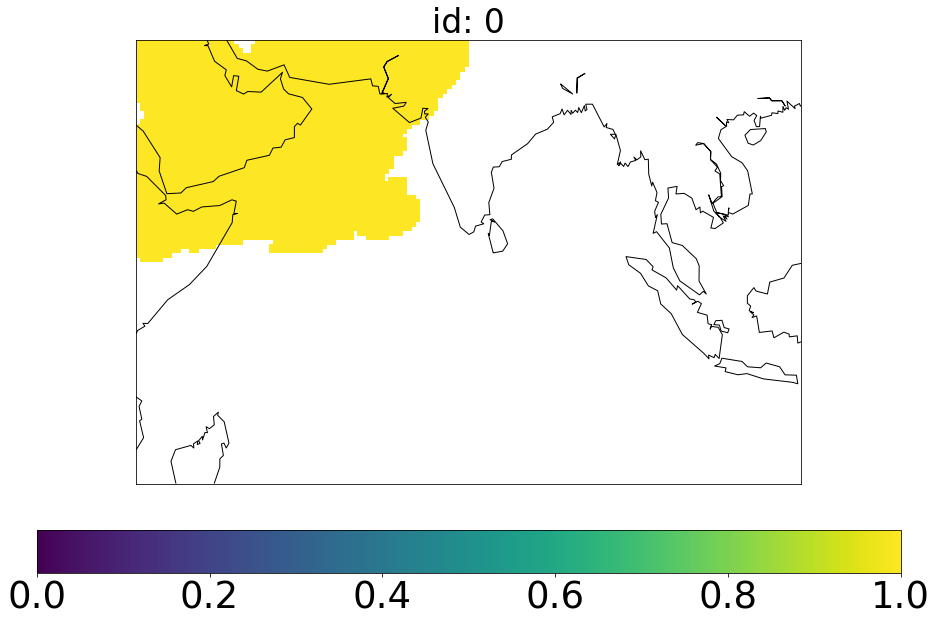

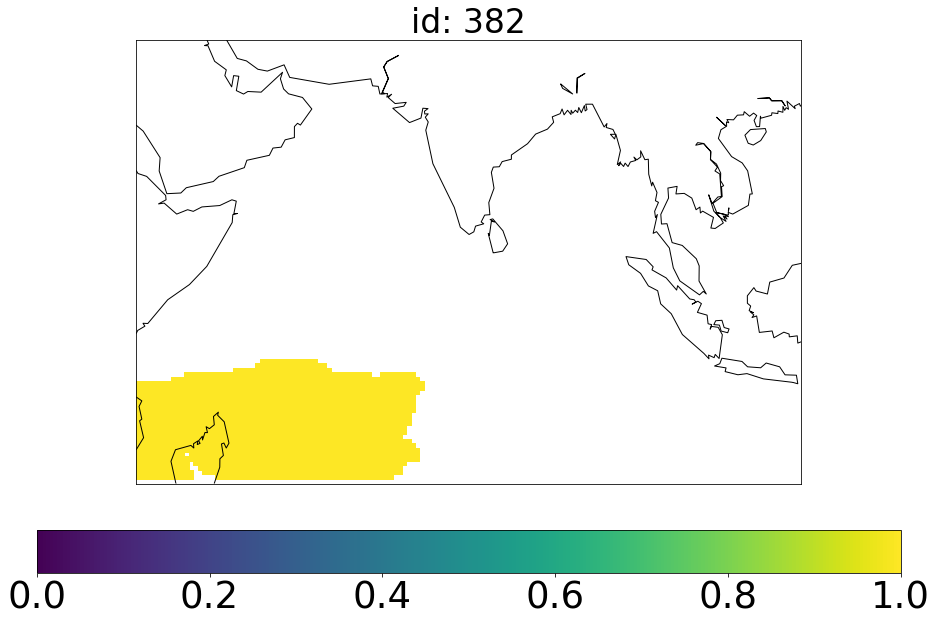

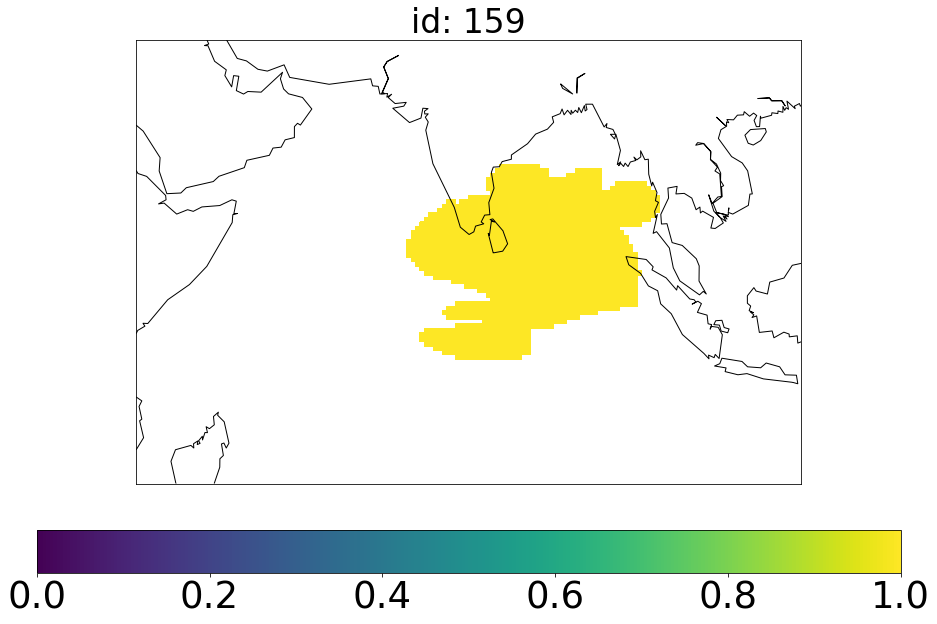

In [46]:
for i in range(len(d_maps_to_plot)):
    plot(d_maps_to_plot[i],1,0,"id: "+str( d_ids[i]))

Let's define a single domain map

In [16]:
# in each domain map d_maps[i], points belonging to the domain are == 1
# if not in the domains they are equal to 0.

# define a single domain map

domain_map = np.zeros((d_maps.shape[1], d_maps.shape[2]))
i = 1
for d in range(len(d_maps)):
    domain_map[d_maps[d] == 1] = i;
    i += 1

In [10]:
# Note: domain_map is a single map with all domains. Different numbers are assigned to
# different domains. Numbers do not mean anything and are only used to differentiate domains.

In [18]:
domain_map[domain_map==0] = np.nan

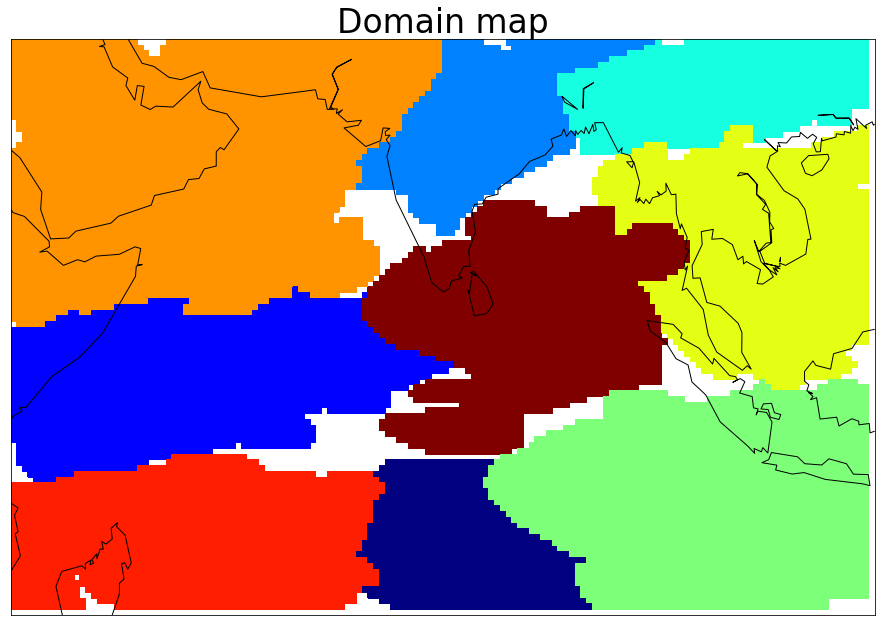

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
    
map = Basemap(projection='cyl',
              llcrnrlat=-20,urcrnrlat=30,\
            llcrnrlon=40,urcrnrlon=115)
map.drawcoastlines()
    #map.drawparallels(np.arange(-90.,100.,30.), \
    #  labels=[1,0,0,0],fontsize = 20,linewidth = 0)
    #map.drawmeridians(np.arange(0.,360.,60.), \
    #  labels=[0,0,0,1],fontsize = 20,linewidth = 0)
#map.fillcontinents(color = 'black')
    
    #cmap=discrete_cmap(50,base_cmap=plt.cm.jet)
map.pcolor(lon,lat,domain_map,cmap=plt.cm.jet)
#cb=plt.colorbar(location='bottom',aspect=20,pad=0.08)
#cb.ax.tick_params(labelsize=37)
    
plt.title('Domain map', fontsize = 33)

plt.show()
#fig.savefig('./domain_map',bbox_inches='tight') # bbox_inches='tight'

## Networks

In [23]:
# Path to the network
path_network = './outputs_test_2/network_inference/network_list.npy'
# Path to the domains strengths
path_domain_strength = './outputs_test_2/network_inference/strength_list.npy'
# Path to the strength map
path_strength_map = './outputs_test_2/network_inference/strength_map.npy'
# Import network
network = np.load(path_network)
# Import domains strength
domain_strength = np.load(path_domain_strength)
# Import the strength map
strength_map = np.load(path_strength_map)

Let's look at the Network list.

Each edge have the following format:

[domain a, domain b, tau_min, tau_max, tau*, r*, weight]

where:

(i) domain_a and domain_b are the ids of the domains considered.

(ii) r* is the max significant correlation

(iii) tau* is the lag correspondent to r*

(iv) [tau_min,tau_max] defines the range of lags associated with significant correlations in the interval [r*-bartlett std(r*),r*+bartlett std(r*)] (i.e., or correlations in this lag range are significant)

(v) link directionality:

if the range [tau_min, tau_max] include zero: domain a <---> domain b

if tau_min > 0: domain a ---> domain b

if tau_max < 0: domain a <--- domain b

(vi) weight is the link weight: covariance at tau*

In [24]:
# Convert the numpy array to a list
network_list = network.tolist()
network_list

[[392.0, 284.0, -4.0, -4.0, -4.0, 0.17451178055872812, 35415429.26574377],
 [392.0, 86.0, -6.0, -6.0, -6.0, -0.1326999376349203, -12345550.912769344],
 [392.0, 253.0, 0.0, 0.0, 0.0, 0.41727992757607085, 103471570.93420295],
 [392.0, 139.0, -4.0, -1.0, -1.0, -0.2079982132283113, -39309039.33459166],
 [392.0, 382.0, 0.0, 0.0, 0.0, 0.2807891646495373, 37209654.505484976],
 [392.0, 159.0, 0.0, 0.0, 0.0, 0.1805403683567897, 28270838.170028605],
 [284.0, 86.0, 0.0, 0.0, 0.0, 0.24469744084624298, 34993690.23954946],
 [284.0, 253.0, -1.0, 0.0, -1.0, -0.3774582702573303, -143874243.6408594],
 [284.0, 139.0, 0.0, 0.0, 0.0, -0.34032843734614043, -98867061.29437973],
 [284.0, 0.0, 0.0, 0.0, 0.0, 0.5159540002046138, 148673851.6904643],
 [284.0, 382.0, 0.0, 0.0, 0.0, 0.35588523119676807, 72494626.7576405],
 [284.0, 159.0, 0.0, 0.0, 0.0, 0.22801033282487335, 54883202.95816235],
 [86.0, 21.0, 0.0, 0.0, 0.0, 0.18433565333032947, 7188477.883492936],
 [86.0, 253.0, 0.0, 0.0, 0.0, -0.19742562877813263, -3

Let's look at the domains strength list.
This is going to be a list with this format

[domain, strength]

(i) domain is the id of the domain considered
(ii) strength is its strength.

Definition.
The strength of a domain is the sum of its weights in absolute value. 
Remember that here the weight between two domains a and b is the covariance of their two signals at a lag tau*, such that their correlation r(tau*) is (i) maximized and (ii) significant.

In [25]:
# Convert the numpy array to a list
strength_list = domain_strength.tolist()
strength_list

[[392.0, 256022083.1228213],
 [284.0, 589202105.8467994],
 [86.0, 190158320.13206285],
 [21.0, 31433384.56711009],
 [253.0, 723538402.5084753],
 [139.0, 557109130.961155],
 [0.0, 494013959.30739856],
 [382.0, 357932238.115785],
 [159.0, 290980745.59031904]]

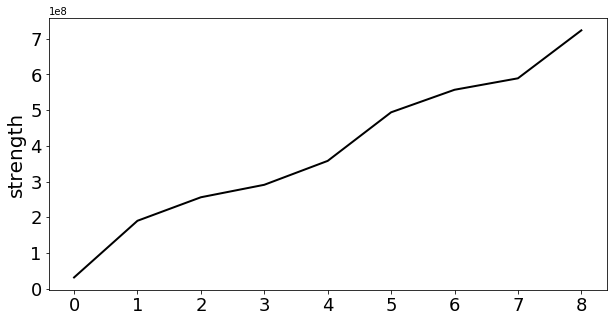

In [26]:
# Sort them and plot them (needless to say, the strongest is ENSO and it is out of scale)
fig = plt.figure(figsize=(10,5))
plt.plot(np.sort(domain_strength[:,1]),"-k",linewidth = 2)
plt.xlabel('',fontsize = 20)
plt.ylabel('strength',fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

Strength map.

Definition.
A strength map is a map where each grid point belonging to a domain A is equal to the strength of the domain.

In [27]:
strength_map[strength_map==0] = np.nan

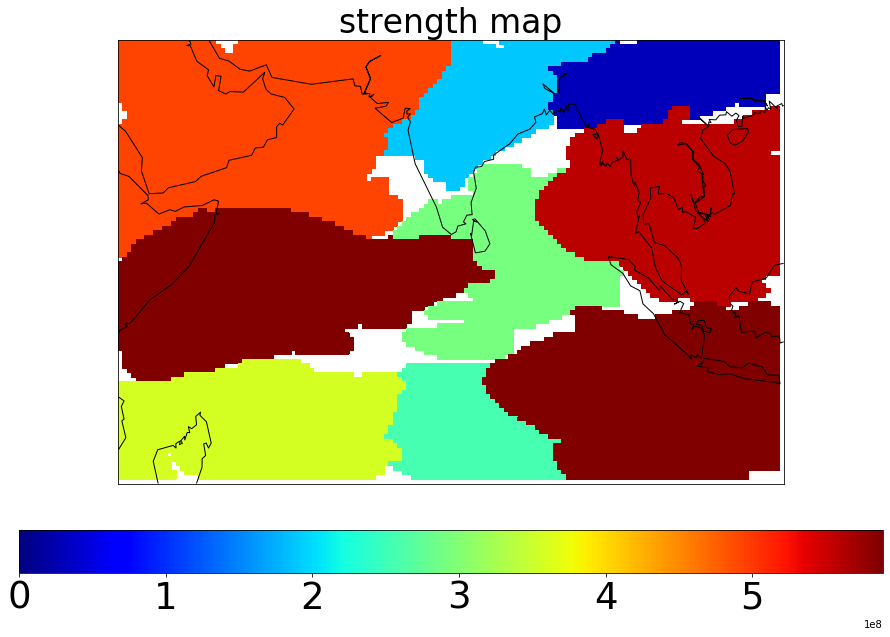

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
    
vmin = 0
vmax = np.sort(domain_strength[:,1])[-2]
    
map = Basemap(projection='cyl',
              llcrnrlat=-20,urcrnrlat=30,\
            llcrnrlon=40,urcrnrlon=115)
map.drawcoastlines()
    #map.drawparallels(np.arange(-90.,100.,30.), \
    #  labels=[1,0,0,0],fontsize = 20,linewidth = 0)
    #map.drawmeridians(np.arange(0.,360.,60.), \
    #  labels=[0,0,0,1],fontsize = 20,linewidth = 0)
#map.fillcontinents(color = 'black')
    
    #cmap=discrete_cmap(50,base_cmap=plt.cm.jet)
map.pcolor(lon,lat,strength_map,cmap=plt.cm.jet,vmin=0,vmax= vmax)
cb=plt.colorbar(location='bottom',aspect=20,pad=0.08)
cb.ax.tick_params(labelsize=37)
    
plt.title('strength map', fontsize = 33)

plt.show()
#fig.savefig('./strength_map',bbox_inches='tight') # bbox_inches='tight'

## Computing the domains signals?

To infer the domains' network we need to compute domains' signals.
We do so by computing the cumulative anomaly inside each domain.

Note: given a set of domains the user could compute their signals and then infer different types of nets, such as causal nets, nonlinear etc.

Here we briefly show how to compute signals from the identified domains in two possible ways:

(a) cumulative sum of all time series inside a domain weighted by their latitudes

(b) average of all time series inside a domain weighted by their latitudes

In [33]:
# Import the dataset (the latitudes and longitudes are already imported at the top of this notebook)
path = '../Data/IO_detrended_anomalies.nc'
olr = importNetcdf(path,'mtnlwrf')
lon = importNetcdf(path,'longitude')
lat = importNetcdf(path,'latitude')

In [35]:
# Function to compute the cumulative domain's anomaly
def cumulative_anomaly(data,domain):
    # input:
    #       (a) data: spatiotemporal climate field (i.e., np.shape(data) = (time, lats, lon))
    #       (b) domain: weighted domain (i.e., np.shape(domain) = (lats, lon))
    # output:
    #       (a) domain's signal:
    #           X(t) = Sum(x_i(t)*cos(phi_i))
    #           where: x_i(t): timeseries at grid point i
    #                  phi_i: latitude of grid point i

    return np.nansum(data*domain,axis=(1,2))

# Function to compute the average domain's anomaly
def average_anomaly(data,domain):
    # input:
    #       (a) data: spatiotemporal climate field (i.e., np.shape(data) = (time, lats, lon))
    #       (b) domain: weighted domain (i.e., np.shape(domain) = (lats, lon))
    # output:
    #       (a) domain's signal:
    #           X(t) = (1/n)Sum(x_i(t)*cos(phi_i))
    #           where: x_i(t): timeseries at grid point i
    #                  phi_i: latitude of grid point i
    #                  n: number of time series in the domain

    # Number of grid cells inside the domain
    n = len(domain[domain>0])
    return (1/n) * np.nansum(data*domain,axis=(1,2))

In [37]:
# Compute all domains signals as the cumulative or average anomaly inside

# Transform latitudes in radians
latitudes = np.radians(lat);
# Assign a weight to each latitude phi
lat_weights = np.cos(latitudes).reshape(len(latitudes),1)
# Define the weighted domain
weighted_domains = d_maps*lat_weights


signals_cumulative = []
signals_average = []
for i in range(len(weighted_domains)):
    signals_cumulative.append(cumulative_anomaly(olr,weighted_domains[i]))
    signals_average.append(average_anomaly(olr,weighted_domains[i])) # in case you want the average anomaly
signals_cumulative = np.array(signals_cumulative)
signals_average = np.array(signals_average)

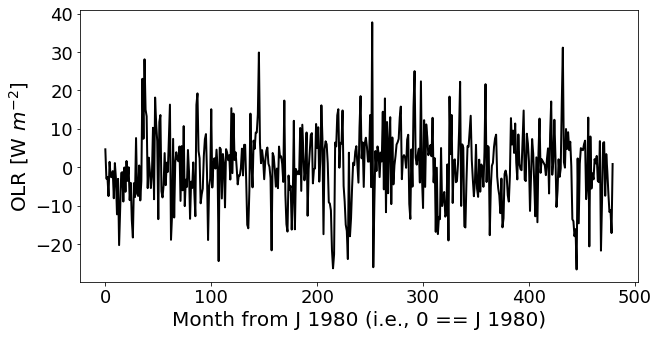

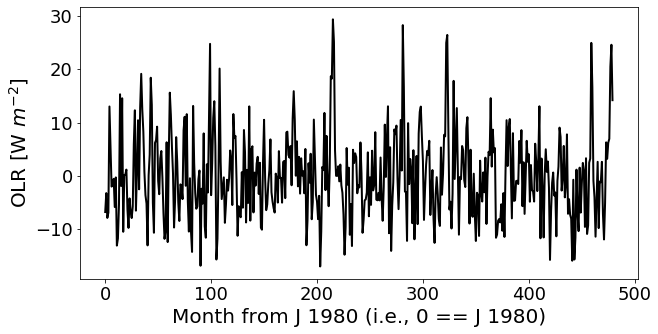

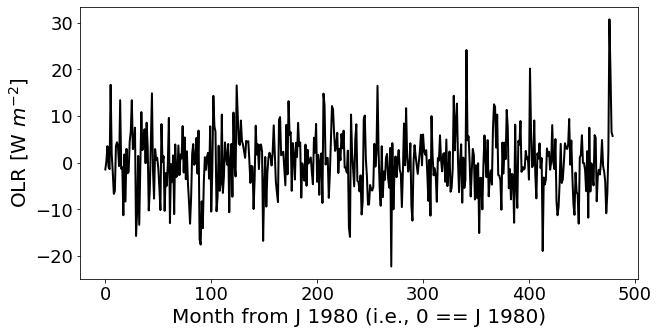

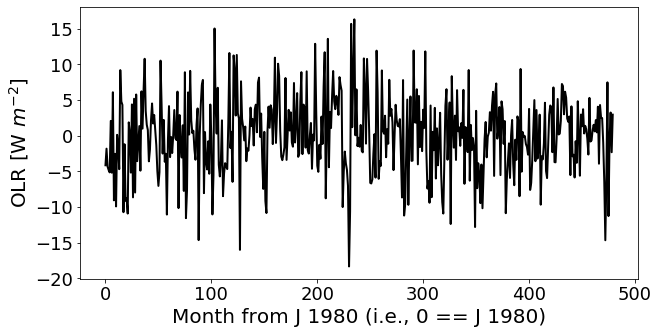

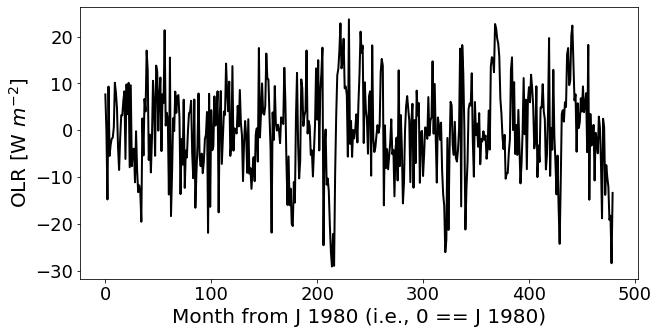

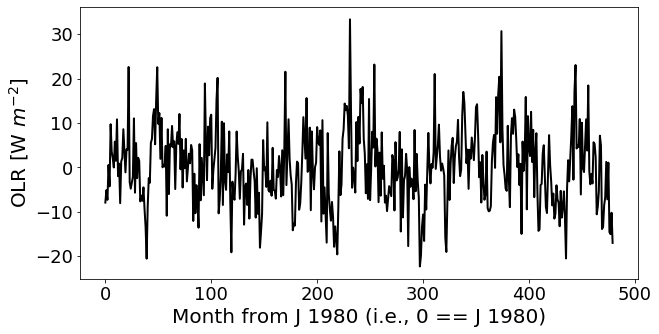

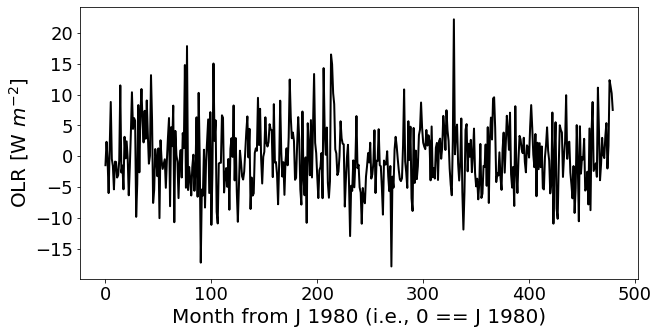

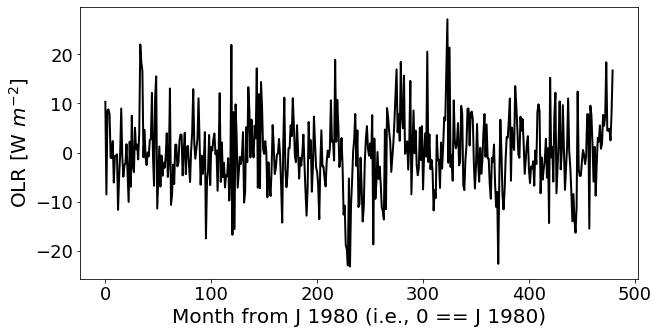

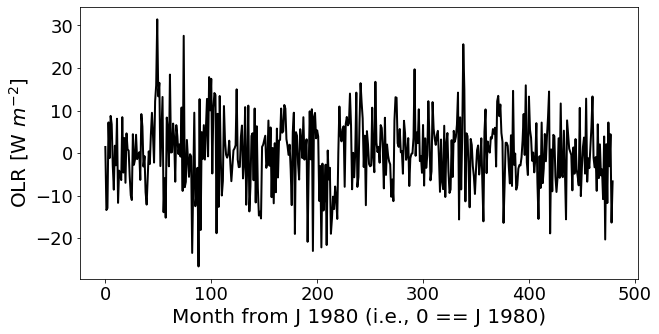

In [38]:
# Let's look at all average signals
for i in range(len(signals_average)):
    fig = plt.figure(figsize=(10,5))
    plt.plot(signals_average[i],"-k",linewidth = 2)
    plt.xlabel('Month from J 1980 (i.e., 0 == J 1980)',fontsize = 20)
    plt.ylabel('OLR [W $m^{-2}$]',fontsize = 20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.show()